<a href="https://colab.research.google.com/github/anirudhs001/3D-ObjectDetection/blob/main/StereoYolo_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### **TARGET_VECTOR** = [\<one-hot-vector for 9 classes == 9 0/1s\>, \<2D bbox\>, \<dimensions\>, \<location\>, \<rotation_y\>]   
total 20 values in single vector    
each target matrix has 32x32 such vectors

where,

**bbox 2D** = (0-based) bounding box of the object: Left, top, right, bottom image coordinates

**dimensions** = 3D object dimensions: height, width, length [m]

**location** = 3D object location x,y,z in camera coords. [m]

**rotation_y** = Rotation around Y-axis in camera coords. [-Pi; Pi]



# Dataset

In [ ]:
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import InterpolationMode
import cv2
from cv2 import cvtColor
import imageio as io
import pandas as pd
import numpy as np

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
import os
def getFiles(filepath):

    left_fold  = 'image_2/'
    right_fold = 'image_3/'
    labels = 'label_2/'
    filenames = [f.split(".")[0] for f in os.listdir(filepath+labels)]
    # print(filenames[:10])

    left_train  = [filepath+left_fold+f"{f}.png" for f in filenames]
    right_train = [filepath+right_fold+f"{f}.png" for f in filenames]
    labels_train = [filepath+labels + f"{f}.txt" for f in filenames]
    
    return left_train, right_train, labels_train

In [ ]:

class customDataset(Dataset): 
    def __init__(self, source_dir, transform=None, transform_disp=None, train=False):
        super().__init__()
        self.source_dir = source_dir
        self.left, self.right, self.labels = getFiles(self.source_dir)
        assert len(self.left) == len(self.right) == len(self.labels)
        self.tfms = transform
        self.tfms_disp = transform_disp
        self.train = train
        
        # for disparity calculation
        self.left_matcher = cv2.StereoSGBM_create(
            minDisparity = 0,
            numDisparities= 128, 
            blockSize=15,
            speckleRange=2
        )

        self.baseline = 0.54
        self.focal_length = 721.5377

    def __len__(self):
        return len(self.left) 
    
    def __getitem__(self, idx):
        left_img = io.imread(self.left[idx])
        left_img = cv2.cvtColor(left_img, cv2.COLOR_BGRA2BGR)
        right_img = io.imread(self.right[idx])
        right_img = cv2.cvtColor(right_img, cv2.COLOR_BGRA2BGR)

        ## RGB TO single channel for disparity computation
        monoL = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
        monoR = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

        ## Disparity computation
        left_disp = self.left_matcher.compute(monoL, monoR)

        ## Depth       
        depth = (self.baseline * self.focal_length) / (left_disp)
        depth = np.clip(depth, 0, 10)
        depth = np.array(depth, dtype=np.float32)

        labels = pd.read_csv(
            self.labels[idx],
            names=["class", "trunc", "occ", "alpha", "left", "top", "right", "bottom", "height", "width", "depth", "locx", "locy", "locz", "rot", "score"], 
            sep=" "
        )
        
        # print(labels)
        if self.train is True:
            labels = labels[['class',  'left',  'top',  'right',  'bottom',  'height',  'width',  'depth',  'locx',  'locy',  'locz',  'rot', "alpha"]]
            for c in classes:
                labels.insert(0, c, 0.)
                for i in labels.index:
                    if labels.loc[i, "class"] == c:
                        labels.loc[i, c] = 1.
            labels = labels.drop('class', axis=1)
            labels = labels.to_numpy()
            # print(labels.shape)
            ## scale labels to resize image size
            labels[:,9] = labels[:,9]  
            labels[:,11] = labels[:,11]
            labels[:,10] = labels[:,10]
            labels[:,12] = labels[:,12]

            targ = torch.zeros((32,32,21))
            x_center = ((labels[:,9] + labels[:,11])/2)*256/org_w # x_center of 2d bounding box
            y_center = ((labels[:,10] + labels[:,12])/2)*256/org_h # y_center of 2d bounding box

            grid_size = 256 / 32 # number of cells in 
            anchor_x = np.clip(np.array(x_center/grid_size).astype(int), 0, 31) # horizontal index where label is stored
            anchor_y = np.clip(np.array(y_center/grid_size).astype(int), 0, 31) # vertical index where label is stored

            for i, (y, x) in enumerate(zip(anchor_y, anchor_x)):
                targ[y,x] = torch.from_numpy(labels[i])
            
            targ = targ.permute(2,0,1)

            if self.tfms is not None:
                left_img = self.tfms(left_img)
                right_img = self.tfms(right_img)
                depth = self.tfms_disp(depth)
                img_tensor = torch.cat((left_img, right_img, depth), 0)
                # print(img_tensor.shape)
                # img_tensor = img_tensor.view(6,370,1224)
                # targ = self.tfms(targ)
                
                return img_tensor, targ
            return left_img, right_img, depth, targ
        return left_img, right_img, labels

In [ ]:

class DisplayDataset(Dataset): 
    def __init__(self, source_dir):
        super().__init__()
        self.source_dir = source_dir
        self.left, self.right, self.labels = getFiles(self.source_dir)
        assert len(self.left) == len(self.right) == len(self.labels)
        
        # for disparity calculation
        self.left_matcher = cv2.StereoSGBM_create(
            minDisparity = 0,
            numDisparities= 128, 
            blockSize=15,
            speckleRange=2
        )

        self.baseline = 0.54
        self.focal_length = 721.5377

    def __len__(self):
        return len(self.left) 
    
    def __getitem__(self, idx):
        left_img = io.imread(self.left[idx])
        left_img = cv2.cvtColor(left_img, cv2.COLOR_BGRA2BGR)
        right_img = io.imread(self.right[idx])
        right_img = cv2.cvtColor(right_img, cv2.COLOR_BGRA2BGR)

        ## RGB TO single channel for disparity computation
        monoL = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
        monoR = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

        ## Disparity computation
        left_disp = self.left_matcher.compute(monoL, monoR)

        ## Depth       
        depth = (self.baseline * self.focal_length) / (left_disp)
        depth = np.clip(depth, 0, 10)
        depth = np.array(depth, dtype=np.float32)

        left_img = TF.to_pil_image(left_img)
        right_img = TF.to_pil_image(right_img)
        depth = TF.to_tensor(depth)
        left_img = TF.to_tensor(left_img)
        right_img = TF.to_tensor(right_img)

        img_tensor = torch.cat((left_img, right_img, depth), 0)
        
        return img_tensor

In [ ]:
classes = ['Car', 'Van',  'Truck', 'Pedestrian',  'Person_sitting', 'Cyclist',  'Tram', 'Misc', 'DontCare']
print(len(classes))

9


In [ ]:
import matplotlib.pyplot as plt
PATH = "drive/MyDrive/playground/training/"

In [ ]:
# IMAGE SIZE
org_h, org_w = 375, 1242
# org_h, org_w = 370, 1224

In [ ]:

load_height = 256
load_width = 256

tfms_train = transforms.Compose([    
    transforms.ToPILImage(),
    transforms.Resize((load_height, load_width)),
    transforms.ToTensor(),
    # transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])                
])

tfms_depth_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((load_height, load_width), interpolation=InterpolationMode.NEAREST),
])


# MODELS

## OLD Nets

### Base

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2 with residual connections"""

    def __init__(self, in_channels, out_channels, mid_channels=None, norm="batch"):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        
        self.res1 = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=False),
        )
        self.res2 = nn.Sequential(
            nn.Conv2d(mid_channels, mid_channels, kernel_size=5, padding=2),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=False),
        )
        self.res3 = nn.Sequential(
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=False)
        )

    def forward(self, x):
        x1 = self.res1(x)
        x1 = x1+self.res2(x1)
        return self.res3(x1)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class AdaptiveInstanceNorm2d(nn.Module):
    def __init__(self):
        super(self).__init__()
    
    def forward(self, x, weight, bias):
        b, c = x.shape[0], x.shape[1]
        x_reshaped = x.contiguous().view(1, b * c, *x.size()[2:])
        running_mean = self.running_mean.repeat(b)
        running_var = self.running_var.repeat(b)
        out = F.batch_norm(
            x_reshaped, running_mean, running_var, weight, bias,
            True, self.momentum, self.eps)
        
        return out.view(b, c, *x.size()[2:])

### OLD NET 1

In [ ]:

#NEW MODELS
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net1 = nn.Sequential(
            DoubleConv(6, 24),
            Down(24, 48),
            DoubleConv(48, 64),
            Down(64, 32),
            DoubleConv(32, 64),
            DoubleConv(64, 128),
            Down(128, 128),
            DoubleConv(128, 64),
            DoubleConv(64, 128),
            DoubleConv(128, 256),
            DoubleConv(256, 512),
            DoubleConv(512, 512),
            DoubleConv(512, 20 ),
            nn.AdaptiveMaxPool2d((32,32)), 
        )
        self.net2 = nn.Sequential(
            nn.Linear(20, 1024),
            nn.ReLU(),
            nn.Linear(1024, 4096),
            nn.ReLU(),
            nn.Linear(4096, 20)
        )

    def forward(self, x):
        x = self.net1(x)
        x = x.view(x.shape[0], x.shape[1], -1)
        x = x.permute(0,2,1) 
        x = self.net2(x)
        x = x.permute(0,2,1)
        x = x.view(x.shape[0], 20, 32, 32)
        x[:,:9] = torch.sigmoid(x[:,:9])
        # x[:,:9] = F.softmax(x[:,:9], dim=1)
        return x

def test():
    model = Net()
    inp = torch.randn((1,6,256,256))
    out = model(inp)
    print(out.shape)
    print(out[0,:,0,0])
    del model
test()

KeyboardInterrupt: ignored

### OLD NET 2

In [ ]:
#NEW MODELS
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net1 = nn.Sequential(
            DoubleConv(6, 24),
            Down(24, 48),
            DoubleConv(48, 64),
            Down(64, 128),
            DoubleConv(128, 64),
            DoubleConv(64, 128),
            Down(128, 128),
            DoubleConv(128, 256),
            DoubleConv(256, 256),
            DoubleConv(256, 512),
            DoubleConv(512, 1024),
            DoubleConv(1024,512),
            DoubleConv(512, 20 ),
            nn.AdaptiveMaxPool2d((32,32)), 
        )
        # self.net2 = nn.Sequential(
            # nn.Linear(20, 1024),
            # nn.ReLU(),
            # nn.Linear(1024, 4096),
            # nn.ReLU(),
            # nn.Linear(4096, 20)
        # )

    def forward(self, x):
        x = self.net1(x)
        # x = x.view(x.shape[0], x.shape[1], -1)
        # x = x.permute(0,2,1) 
        # x = self.net2(x)
        # x = x.permute(0,2,1)
        # x = x.view(x.shape[0], 20, 32, 32)
        # x[:,:9] = torch.sigmoid(x[:,:9])

        x_probs = x[:,:9]
        x_preds = x[:,9:]
        x_probs = F.softmax(x_probs, dim=1)
        out = torch.cat((x_probs, x_preds), dim=1)
        # x[:,:9] = F.softmax(x[:,:9], dim=1)
        return out

def test():
    model = Net()
    inp = torch.randn((1,6,256,256))
    out = model(inp)
    print(out.shape)
    print(out[0,:,0,0])
    del model
test()

torch.Size([1, 20, 32, 32])
tensor([0.1045, 0.2258, 0.1676, 0.0639, 0.0639, 0.0639, 0.0639, 0.1815, 0.0652,
        0.1254, 0.0000, 0.0000, 0.4507, 0.4542, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0074, 0.5364], grad_fn=<SelectBackward>)


In [ ]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
print(dev)

cpu


In [ ]:
path_to_load = "drive/MyDrive/playground/StereoYolo/"


## HRNet

### HRNet base

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=0.1)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=0.1)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion, momentum=0.1)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=0.1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=0.1)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
class HighResolutionModule(nn.Module):
    def __init__(self, num_branches, blocks, num_blocks, num_inchannels,
                 num_channels, fuse_method, multi_scale_output=True):
        super().__init__()
        self._check_branches(
            num_branches, blocks, num_blocks, num_inchannels, num_channels)

        self.num_inchannels = num_inchannels
        self.fuse_method = fuse_method
        self.num_branches = num_branches

        self.multi_scale_output = multi_scale_output

        self.branches = self._make_branches(
            num_branches, blocks, num_blocks, num_channels)
        self.fuse_layers = self._make_fuse_layers()
        self.relu = nn.ReLU(inplace=False)

    def _check_branches(self, num_branches, blocks, num_blocks,
                        num_inchannels, num_channels):
        if num_branches != len(num_blocks):
            error_msg = 'NUM_BRANCHES({}) <> NUM_BLOCKS({})'.format(
                num_branches, len(num_blocks))
            logger.error(error_msg)
            raise ValueError(error_msg)

        if num_branches != len(num_channels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_CHANNELS({})'.format(
                num_branches, len(num_channels))
            logger.error(error_msg)
            raise ValueError(error_msg)

        if num_branches != len(num_inchannels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_INCHANNELS({})'.format(
                num_branches, len(num_inchannels))
            logger.error(error_msg)
            raise ValueError(error_msg)

    def _make_one_branch(self, branch_index, block, num_blocks, num_channels,
                         stride=1):
        downsample = None
        if stride != 1 or \
           self.num_inchannels[branch_index] != num_channels[branch_index] * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.num_inchannels[branch_index],
                          num_channels[branch_index] * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(num_channels[branch_index] * block.expansion,
                            momentum=0.1),
            )

        layers = []
        layers.append(block(self.num_inchannels[branch_index],
                            num_channels[branch_index], stride, downsample))
        self.num_inchannels[branch_index] = \
            num_channels[branch_index] * block.expansion
        for i in range(1, num_blocks[branch_index]):
            layers.append(block(self.num_inchannels[branch_index],
                                num_channels[branch_index]))

        return nn.Sequential(*layers)

    def _make_branches(self, num_branches, block, num_blocks, num_channels):
        branches = []

        for i in range(num_branches):
            branches.append(
                self._make_one_branch(i, block, num_blocks, num_channels))

        return nn.ModuleList(branches)

    def _make_fuse_layers(self):
        if self.num_branches == 1:
            return None

        num_branches = self.num_branches
        num_inchannels = self.num_inchannels
        fuse_layers = []
        for i in range(num_branches if self.multi_scale_output else 1):
            fuse_layer = []
            for j in range(num_branches):
                if j > i:
                    fuse_layer.append(nn.Sequential(
                        nn.Conv2d(num_inchannels[j],
                                  num_inchannels[i],
                                  1,
                                  1,
                                  0,
                                  bias=False),
                        nn.BatchNorm2d(num_inchannels[i], momentum=0.1)))
                elif j == i:
                    fuse_layer.append(None)
                else:
                    conv3x3s = []
                    for k in range(i-j):
                        if k == i - j - 1:
                            num_outchannels_conv3x3 = num_inchannels[i]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                nn.BatchNorm2d(num_outchannels_conv3x3, 
                                            momentum=0.1)))
                        else:
                            num_outchannels_conv3x3 = num_inchannels[j]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                nn.BatchNorm2d(num_outchannels_conv3x3,
                                            momentum=0.1),
                                nn.ReLU(inplace=False)))
                    fuse_layer.append(nn.Sequential(*conv3x3s))
            fuse_layers.append(nn.ModuleList(fuse_layer))

        return nn.ModuleList(fuse_layers)

    def get_num_inchannels(self):
        return self.num_inchannels

    def forward(self, x):
        if self.num_branches == 1:
            return [self.branches[0](x[0])]

        for i in range(self.num_branches):
            x[i] = self.branches[i](x[i])

        x_fuse = []
        for i in range(len(self.fuse_layers)):
            y = x[0] if i == 0 else self.fuse_layers[i][0](x[0])
            for j in range(1, self.num_branches):
                if i == j:
                    y = y + x[j]
                elif j > i:
                    width_output = x[i].shape[-1]
                    height_output = x[i].shape[-2]
                    y = y + F.interpolate(
                        self.fuse_layers[i][j](x[j]),
                        size=[height_output, width_output],
                        mode='bilinear')
                else:
                    y = y + self.fuse_layers[i][j](x[j])
            x_fuse.append(self.relu(y))

        return x_fuse




### Regular HRnet

In [ ]:
blocks_dict = {
    'BASIC': BasicBlock,
    'BOTTLENECK': Bottleneck
}
class HighResolutionNet(nn.Module):

    def __init__(self):
        super().__init__()

        # stem net
        self.conv1 = nn.Conv2d(6, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64, momentum=0.1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(64, momentum=0.1)
        self.relu = nn.ReLU(inplace=False)

        self.stage1_cfg = {
            'NUM_MODULES' : 1,
            'NUM_BRANCHES' : 1,
            'NUM_BLOCKS' : [4],
            'NUM_CHANNELS' : [32],
            'BLOCK' : 'BOTTLENECK',
            'FUSE_METHOD' : 'SUM',

        }
        num_channels = self.stage1_cfg['NUM_CHANNELS'][0]
        block = blocks_dict[self.stage1_cfg['BLOCK']]
        num_blocks = self.stage1_cfg['NUM_BLOCKS'][0]
        self.layer1 = self._make_layer(block, 64, num_channels, num_blocks)
        stage1_out_channel = block.expansion*num_channels

        self.stage2_cfg = {
            'NUM_MODULES' : 1,
            'NUM_BRANCHES' : 2,
            'NUM_BLOCKS' : [4, 4],
            'NUM_CHANNELS' : [32, 64],
            'BLOCK' : 'BASIC',
            'FUSE_METHOD' : 'SUM',

        }
        num_channels = self.stage2_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage2_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition1 = self._make_transition_layer(
            [stage1_out_channel], num_channels)
        self.stage2, pre_stage_channels = self._make_stage(
            self.stage2_cfg, num_channels)

        self.stage3_cfg = {
            'NUM_MODULES' : 1,
            'NUM_BRANCHES' : 3,
            'NUM_BLOCKS' : [4, 4, 4],
            'NUM_CHANNELS' : [32, 64, 128],
            'BLOCK' : 'BASIC',
            'FUSE_METHOD' : 'SUM',

        }
        num_channels = self.stage3_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage3_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition2 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage3, pre_stage_channels = self._make_stage(
            self.stage3_cfg, num_channels)
        self.stage4_cfg = {
            'NUM_MODULES' : 1,
            'NUM_BRANCHES' : 4,
            'NUM_BLOCKS' : [4, 4, 4, 4],
            'NUM_CHANNELS' : [32, 64, 128, 256],
            'BLOCK' : 'BASIC',
            'FUSE_METHOD' : 'SUM',

        }
        num_channels = self.stage4_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage4_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition3 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage4, pre_stage_channels = self._make_stage(
            self.stage4_cfg, num_channels, multi_scale_output=True)

        last_inp_channels = int(np.sum(pre_stage_channels))
        last_out_channels = 20
        self.last_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=last_out_channels,
                kernel_size=3,
                stride=1,
                padding=0),
            nn.BatchNorm2d(last_out_channels, momentum=0.1),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=4),
            nn.Conv2d(
                in_channels=last_out_channels,
                out_channels=last_out_channels,
                kernel_size=1,
                stride=1,
                padding=1 ),
            nn.BatchNorm2d(last_out_channels, momentum=0.1),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=last_out_channels,
                out_channels=last_out_channels,
                kernel_size=1,
                stride=1)

        )
        self.prob_layer = nn.Sigmoid()

    def _make_transition_layer(
            self, num_channels_pre_layer, num_channels_cur_layer):
        num_branches_cur = len(num_channels_cur_layer)
        num_branches_pre = len(num_channels_pre_layer)

        transition_layers = []
        for i in range(num_branches_cur):
            if i < num_branches_pre:
                if num_channels_cur_layer[i] != num_channels_pre_layer[i]:
                    transition_layers.append(nn.Sequential(
                        nn.Conv2d(num_channels_pre_layer[i],
                                  num_channels_cur_layer[i],
                                  3,
                                  1,
                                  1,
                                  bias=False),
                        nn.BatchNorm2d(
                            num_channels_cur_layer[i], momentum=0.1),
                        nn.ReLU(inplace=False)))
                else:
                    transition_layers.append(None)
            else:
                conv3x3s = []
                for j in range(i+1-num_branches_pre):
                    inchannels = num_channels_pre_layer[-1]
                    outchannels = num_channels_cur_layer[i] \
                        if j == i-num_branches_pre else inchannels
                    conv3x3s.append(nn.Sequential(
                        nn.Conv2d(
                            inchannels, outchannels, 3, 2, 1, bias=False),
                        nn.BatchNorm2d(outchannels, momentum=0.1),
                        nn.ReLU(inplace=False)))
                transition_layers.append(nn.Sequential(*conv3x3s))

        return nn.ModuleList(transition_layers)

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=0.1),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(inplanes, planes))

        return nn.Sequential(*layers)

    def _make_stage(self, layer_config, num_inchannels,
                    multi_scale_output=True):
        num_modules = layer_config['NUM_MODULES']
        num_branches = layer_config['NUM_BRANCHES']
        num_blocks = layer_config['NUM_BLOCKS']
        num_channels = layer_config['NUM_CHANNELS']
        block = blocks_dict[layer_config['BLOCK']]
        fuse_method = layer_config['FUSE_METHOD']

        modules = []
        for i in range(num_modules):
            # multi_scale_output is only used last module
            if not multi_scale_output and i == num_modules - 1:
                reset_multi_scale_output = False
            else:
                reset_multi_scale_output = True
            modules.append(
                HighResolutionModule(num_branches,
                                      block,
                                      num_blocks,
                                      num_inchannels,
                                      num_channels,
                                      fuse_method,
                                      reset_multi_scale_output)
            )
            num_inchannels = modules[-1].get_num_inchannels()

        return nn.Sequential(*modules), num_inchannels

    def forward(self, x ):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.layer1(x)

        x_list = []
        for i in range(2):
            if self.transition1[i] is not None:
                x_list.append(self.transition1[i](x))
            else:
                x_list.append(x)
        y_list = self.stage2(x_list)

        x_list = []
        for i in range(3):
            if self.transition2[i] is not None:
                if i < 2:
                    x_list.append(self.transition2[i](y_list[i]))
                else:
                    x_list.append(self.transition2[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        y_list = self.stage3(x_list)

        x_list = []
        for i in range(self.stage4_cfg['NUM_BRANCHES']):
            if self.transition3[i] is not None:
                if i < self.stage3_cfg['NUM_BRANCHES']:
                    x_list.append(self.transition3[i](y_list[i]))
                else:
                    x_list.append(self.transition3[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        x = self.stage4(x_list)

#         # Upsampling
        x0_h, x0_w = x[0].size(2), x[0].size(3)

        x1 = F.interpolate(x[1], size=(x0_h, x0_w), mode='bilinear', align_corners=True)
        x2 = F.interpolate(x[2], size=(x0_h, x0_w), mode='bilinear', align_corners=True)
        x3 = F.interpolate(x[3], size=(x0_h, x0_w), mode='bilinear', align_corners=True)
        x = torch.cat([x[0], x1, x2, x3], 1)

        x = self.last_layer(x)
        x = torch.cat((self.prob_layer(x[:,:9,:,:]), x[:,9:,:,:]), dim=1)
        return x


### Testing net

In [ ]:
## sanity check for model output
def test():
    model = HighResolutionNet()
    inp = torch.randn((1,6,256,256))
    out = model(inp)
    print(type(out))
    print(out.shape)
    print(out[0,:,0,0])
    del model
test()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


<class 'torch.Tensor'>
torch.Size([1, 20, 32, 32])
tensor([ 0.5438,  0.3141,  0.5962,  0.3751,  0.5862,  0.2335,  0.6102,  0.5100,
         0.3838, -0.0115, -0.5568,  0.1502,  0.4931,  0.4333,  1.3793,  0.3297,
         0.6384, -0.6008,  0.6067,  0.6351], grad_fn=<SelectBackward>)


### Mod HRnet

In [ ]:
blocks_dict = {
    'BASIC': BasicBlock,
    'BOTTLENECK': Bottleneck
}
class HighResolutionNet(nn.Module):

    def __init__(self):
        super().__init__()

        # stem net
        self.conv1 = nn.Conv2d(7, 64, kernel_size=5, stride=1, padding=2,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64, momentum=0.1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(64, momentum=0.1)
        self.relu = nn.ReLU(inplace=False)

        self.stage1_cfg = {
            'NUM_MODULES' : 1,
            'NUM_BRANCHES' : 1,
            'NUM_BLOCKS' : [4],
            'NUM_CHANNELS' : [16],
            'BLOCK' : 'BOTTLENECK',
            'FUSE_METHOD' : 'SUM',

        }
        num_channels = self.stage1_cfg['NUM_CHANNELS'][0]
        block = blocks_dict[self.stage1_cfg['BLOCK']]
        num_blocks = self.stage1_cfg['NUM_BLOCKS'][0]
        self.layer1 = self._make_layer(block, 64, num_channels, num_blocks)
        stage1_out_channel = block.expansion*num_channels

        self.stage2_cfg = {
            'NUM_MODULES' : 1,
            'NUM_BRANCHES' : 2,
            'NUM_BLOCKS' : [4, 4],
            'NUM_CHANNELS' : [16, 32],
            'BLOCK' : 'BASIC',
            'FUSE_METHOD' : 'SUM',

        }
        num_channels = self.stage2_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage2_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition1 = self._make_transition_layer(
            [stage1_out_channel], num_channels)
        self.stage2, pre_stage_channels = self._make_stage(
            self.stage2_cfg, num_channels)

        self.stage3_cfg = {
            'NUM_MODULES' : 1,
            'NUM_BRANCHES' : 3,
            'NUM_BLOCKS' : [4, 4, 4],
            'NUM_CHANNELS' : [16, 32, 64],
            'BLOCK' : 'BASIC',
            'FUSE_METHOD' : 'SUM',

        }
        num_channels = self.stage3_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage3_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition2 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage3, pre_stage_channels = self._make_stage(
            self.stage3_cfg, num_channels)
        self.stage4_cfg = {
            'NUM_MODULES' : 1,
            'NUM_BRANCHES' : 4,
            'NUM_BLOCKS' : [4, 4, 4, 4],
            'NUM_CHANNELS' : [16, 32, 64, 128],
            'BLOCK' : 'BASIC',
            'FUSE_METHOD' : 'SUM',

        }
        num_channels = self.stage4_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage4_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition3 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage4, pre_stage_channels = self._make_stage(
            self.stage4_cfg, num_channels, multi_scale_output=True)

        last_inp_channels = int(np.sum(pre_stage_channels))
        last_out_channels = 20
        self.second_last_layer = nn.Sequential(
            nn.MaxPool2d(kernel_size=4),
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=last_inp_channels,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.BatchNorm2d(last_inp_channels, momentum=0.1),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2),
            
        )
        self.last_layer = nn.Sequential(
            nn.Linear(last_inp_channels, 100),
            nn.ReLU(),
            nn.Linear(100, last_out_channels),
            nn.ReLU(),
        )
        self.prob_layer = nn.Sigmoid()

    def _make_transition_layer(
            self, num_channels_pre_layer, num_channels_cur_layer):
        num_branches_cur = len(num_channels_cur_layer)
        num_branches_pre = len(num_channels_pre_layer)

        transition_layers = []
        for i in range(num_branches_cur):
            if i < num_branches_pre:
                if num_channels_cur_layer[i] != num_channels_pre_layer[i]:
                    transition_layers.append(nn.Sequential(
                        nn.Conv2d(num_channels_pre_layer[i],
                                  num_channels_cur_layer[i],
                                  3,
                                  1,
                                  1,
                                  bias=False),
                        nn.BatchNorm2d(
                            num_channels_cur_layer[i], momentum=0.1),
                        nn.ReLU(inplace=False)))
                else:
                    transition_layers.append(None)
            else:
                conv3x3s = []
                for j in range(i+1-num_branches_pre):
                    inchannels = num_channels_pre_layer[-1]
                    outchannels = num_channels_cur_layer[i] \
                        if j == i-num_branches_pre else inchannels
                    conv3x3s.append(nn.Sequential(
                        nn.Conv2d(
                            inchannels, outchannels, 3, 2, 1, bias=False),
                        nn.BatchNorm2d(outchannels, momentum=0.1),
                        nn.ReLU(inplace=False)))
                transition_layers.append(nn.Sequential(*conv3x3s))

        return nn.ModuleList(transition_layers)

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=0.1),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(inplanes, planes))

        return nn.Sequential(*layers)

    def _make_stage(self, layer_config, num_inchannels,
                    multi_scale_output=True):
        num_modules = layer_config['NUM_MODULES']
        num_branches = layer_config['NUM_BRANCHES']
        num_blocks = layer_config['NUM_BLOCKS']
        num_channels = layer_config['NUM_CHANNELS']
        block = blocks_dict[layer_config['BLOCK']]
        fuse_method = layer_config['FUSE_METHOD']

        modules = []
        for i in range(num_modules):
            # multi_scale_output is only used last module
            if not multi_scale_output and i == num_modules - 1:
                reset_multi_scale_output = False
            else:
                reset_multi_scale_output = True
            modules.append(
                HighResolutionModule(num_branches,
                                      block,
                                      num_blocks,
                                      num_inchannels,
                                      num_channels,
                                      fuse_method,
                                      reset_multi_scale_output)
            )
            num_inchannels = modules[-1].get_num_inchannels()

        return nn.Sequential(*modules), num_inchannels

    def forward(self, x ):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.layer1(x)

        x_list = []
        for i in range(2):
            if self.transition1[i] is not None:
                x_list.append(self.transition1[i](x))
            else:
                x_list.append(x)
        y_list = self.stage2(x_list)

        x_list = []
        for i in range(3):
            if self.transition2[i] is not None:
                if i < 2:
                    x_list.append(self.transition2[i](y_list[i]))
                else:
                    x_list.append(self.transition2[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        y_list = self.stage3(x_list)

        x_list = []
        for i in range(self.stage4_cfg['NUM_BRANCHES']):
            if self.transition3[i] is not None:
                if i < self.stage3_cfg['NUM_BRANCHES']:
                    x_list.append(self.transition3[i](y_list[i]))
                else:
                    x_list.append(self.transition3[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        x = self.stage4(x_list)

#         # Upsampling
        x0_h, x0_w = x[0].size(2), x[0].size(3)

        x1 = F.interpolate(x[1], size=(x0_h, x0_w), mode='bilinear', align_corners=True)
        x2 = F.interpolate(x[2], size=(x0_h, x0_w), mode='bilinear', align_corners=True)
        x3 = F.interpolate(x[3], size=(x0_h, x0_w), mode='bilinear', align_corners=True)
        x = torch.cat([x[0], x1, x2, x3], 1)

        x = self.second_last_layer(x)
        x = x.permute(0,2,3,1)
        x = self.last_layer(x)
        x = x.permute(0,3,1,2)
        x = torch.cat((self.prob_layer(x[:,:9,:,:]), x[:,9:,:,:]), dim=1)
        return x


## MOD HRnet2

In [ ]:
blocks_dict = {
    'BASIC': BasicBlock,
    'BOTTLENECK': Bottleneck
}
class HighResolutionNet(nn.Module):

    def __init__(self):
        super().__init__()

        # stem net
        self.conv1 = nn.Conv2d(7, 64, kernel_size=5, stride=1, padding=2,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64, momentum=0.1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(64, momentum=0.1)
        self.relu = nn.ReLU(inplace=False)

        self.stage1_cfg = {
            'NUM_MODULES' : 1,
            'NUM_BRANCHES' : 1,
            'NUM_BLOCKS' : [4],
            'NUM_CHANNELS' : [16],
            'BLOCK' : 'BOTTLENECK',
            'FUSE_METHOD' : 'SUM',

        }
        num_channels = self.stage1_cfg['NUM_CHANNELS'][0]
        block = blocks_dict[self.stage1_cfg['BLOCK']]
        num_blocks = self.stage1_cfg['NUM_BLOCKS'][0]
        self.layer1 = self._make_layer(block, 64, num_channels, num_blocks)
        stage1_out_channel = block.expansion*num_channels

        self.stage2_cfg = {
            'NUM_MODULES' : 1,
            'NUM_BRANCHES' : 2,
            'NUM_BLOCKS' : [4, 4],
            'NUM_CHANNELS' : [16, 32],
            'BLOCK' : 'BASIC',
            'FUSE_METHOD' : 'SUM',

        }
        num_channels = self.stage2_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage2_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition1 = self._make_transition_layer(
            [stage1_out_channel], num_channels)
        self.stage2, pre_stage_channels = self._make_stage(
            self.stage2_cfg, num_channels)

        self.stage3_cfg = {
            'NUM_MODULES' : 1,
            'NUM_BRANCHES' : 3,
            'NUM_BLOCKS' : [4, 4, 4],
            'NUM_CHANNELS' : [16, 32, 64],
            'BLOCK' : 'BASIC',
            'FUSE_METHOD' : 'SUM',

        }
        num_channels = self.stage3_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage3_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition2 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage3, pre_stage_channels = self._make_stage(
            self.stage3_cfg, num_channels)
        self.stage4_cfg = {
            'NUM_MODULES' : 1,
            'NUM_BRANCHES' : 4,
            'NUM_BLOCKS' : [4, 4, 4, 4],
            'NUM_CHANNELS' : [16, 32, 64, 128],
            'BLOCK' : 'BASIC',
            'FUSE_METHOD' : 'SUM',

        }
        num_channels = self.stage4_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage4_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition3 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage4, pre_stage_channels = self._make_stage(
            self.stage4_cfg, num_channels, multi_scale_output=True)

        last_inp_channels = int(np.sum(pre_stage_channels))
        last_out_channels = 21
        self.second_last_layer = nn.Sequential(
            nn.MaxPool2d(kernel_size=4),
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=last_inp_channels,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.BatchNorm2d(last_inp_channels, momentum=0.1),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=last_inp_channels,
                kernel_size=1)
            
        )
        self.last_layer = nn.Sequential(
            nn.Linear(last_inp_channels, 1024),
            nn.ReLU(),
            nn.Linear(1024, last_out_channels),
        )
        self.prob_layer = nn.Sigmoid()

    def _make_transition_layer(
            self, num_channels_pre_layer, num_channels_cur_layer):
        num_branches_cur = len(num_channels_cur_layer)
        num_branches_pre = len(num_channels_pre_layer)

        transition_layers = []
        for i in range(num_branches_cur):
            if i < num_branches_pre:
                if num_channels_cur_layer[i] != num_channels_pre_layer[i]:
                    transition_layers.append(nn.Sequential(
                        nn.Conv2d(num_channels_pre_layer[i],
                                  num_channels_cur_layer[i],
                                  3,
                                  1,
                                  1,
                                  bias=False),
                        nn.BatchNorm2d(
                            num_channels_cur_layer[i], momentum=0.1),
                        nn.ReLU(inplace=False)))
                else:
                    transition_layers.append(None)
            else:
                conv3x3s = []
                for j in range(i+1-num_branches_pre):
                    inchannels = num_channels_pre_layer[-1]
                    outchannels = num_channels_cur_layer[i] \
                        if j == i-num_branches_pre else inchannels
                    conv3x3s.append(nn.Sequential(
                        nn.Conv2d(
                            inchannels, outchannels, 3, 2, 1, bias=False),
                        nn.BatchNorm2d(outchannels, momentum=0.1),
                        nn.ReLU(inplace=False)))
                transition_layers.append(nn.Sequential(*conv3x3s))

        return nn.ModuleList(transition_layers)

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=0.1),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(inplanes, planes))

        return nn.Sequential(*layers)

    def _make_stage(self, layer_config, num_inchannels,
                    multi_scale_output=True):
        num_modules = layer_config['NUM_MODULES']
        num_branches = layer_config['NUM_BRANCHES']
        num_blocks = layer_config['NUM_BLOCKS']
        num_channels = layer_config['NUM_CHANNELS']
        block = blocks_dict[layer_config['BLOCK']]
        fuse_method = layer_config['FUSE_METHOD']

        modules = []
        for i in range(num_modules):
            # multi_scale_output is only used last module
            if not multi_scale_output and i == num_modules - 1:
                reset_multi_scale_output = False
            else:
                reset_multi_scale_output = True
            modules.append(
                HighResolutionModule(num_branches,
                                      block,
                                      num_blocks,
                                      num_inchannels,
                                      num_channels,
                                      fuse_method,
                                      reset_multi_scale_output)
            )
            num_inchannels = modules[-1].get_num_inchannels()

        return nn.Sequential(*modules), num_inchannels

    def forward(self, x ):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.layer1(x)

        x_list = []
        for i in range(2):
            if self.transition1[i] is not None:
                x_list.append(self.transition1[i](x))
            else:
                x_list.append(x)
        y_list = self.stage2(x_list)

        x_list = []
        for i in range(3):
            if self.transition2[i] is not None:
                if i < 2:
                    x_list.append(self.transition2[i](y_list[i]))
                else:
                    x_list.append(self.transition2[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        y_list = self.stage3(x_list)

        x_list = []
        for i in range(self.stage4_cfg['NUM_BRANCHES']):
            if self.transition3[i] is not None:
                if i < self.stage3_cfg['NUM_BRANCHES']:
                    x_list.append(self.transition3[i](y_list[i]))
                else:
                    x_list.append(self.transition3[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        x = self.stage4(x_list)

#         # Upsampling
        x0_h, x0_w = x[0].size(2), x[0].size(3)

        x1 = F.interpolate(x[1], size=(x0_h, x0_w), mode='bilinear', align_corners=True)
        x2 = F.interpolate(x[2], size=(x0_h, x0_w), mode='bilinear', align_corners=True)
        x3 = F.interpolate(x[3], size=(x0_h, x0_w), mode='bilinear', align_corners=True)
        x = torch.cat([x[0], x1, x2, x3], 1)

        x = self.second_last_layer(x)
#         print(x.shape)
        x = x.permute(0,2,3,1)
#         print(x.shape)
        x = self.last_layer(x)
#         print(x.shape)
        x = x.permute(0,3,1,2)
#         print(x.shape)
        x = torch.cat((self.prob_layer(x[:,:9,:,:]), x[:,9:,:,:]), dim=1)
        return x


# inference

In [ ]:
# Fastai instead
from fastai import *
from fastai.vision import *
import imageio as io


In [ ]:
pip freeze | grep fast*

fastai==1.0.61
fastdtw==0.3.4
fastprogress==1.0.0
fastrlock==0.6


In [ ]:
# new dataset with train and validation split for fastai
class FastDataset(customDataset):
    def __init__(self, train=False, split_pct=0.8, source_dir=None, tfms=None, tfms_disp=None):
        super().__init__(source_dir, transform=tfms, transform_disp=tfms_disp, train=True)

        split = int(len(self) * split_pct)
        if train==True:
            self.left = self.left[:split]
            self.right = self.right[:split]
            self.labels = self.labels[:split]
        else:
            self.left = self.left[-split:]
            self.right = self.right[-split:]
            self.labels = self.labels[-split:]


class FastDisplayDataset(DisplayDataset):
    def __init__(self, split_pct=0.8, source_dir=None, train=True):
        super().__init__(source_dir)

        split = int(len(self) * split_pct)
        if train==True:
            self.left = self.left[:split]
            self.right = self.right[:split]
            self.labels = self.labels[:split]
        else:
            self.left = self.left[-split:]
            self.right = self.right[-split:]
            self.labels = self.labels[-split:]

In [ ]:
train_ds = FastDataset(
    train=True, 
    split_pct=0.05, 
    source_dir=PATH, 
    tfms=tfms_train, 
    tfms_disp=tfms_depth_train)

display_ds = FastDisplayDataset(
    split_pct=0.05, 
    source_dir=PATH,
    train=True)

print(len(train_ds))
print(len(display_ds))

374
374


In [ ]:
dev = "cpu"
net = HighResolutionNet().to(dev)


In [ ]:
# path_to_load = "drive/MyDrive/playground/StereoHRNet/models/"
path_to_load = "./"
params = torch.load(f"{path_to_load}model_epoch_15.pth", map_location="cpu")
# params['model']

FileNotFoundError: ignored

In [ ]:
net.load_state_dict(params['model'])

<All keys matched successfully>

In [ ]:
net.eval();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


tensor([  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   1.0000, 350.7200, 192.4100, 387.5300, 223.1800,   1.6500,
          1.7500,   3.3900, -14.1100,   2.8200,  42.0900,   1.1700,   1.4900])
tensor([  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   1.0000, 242.6600, 194.1500, 451.8300, 336.9700,   1.4700,
          1.7000,   4.3900,  -3.4300,   1.8200,  10.1700,   1.4800,   1.8000])


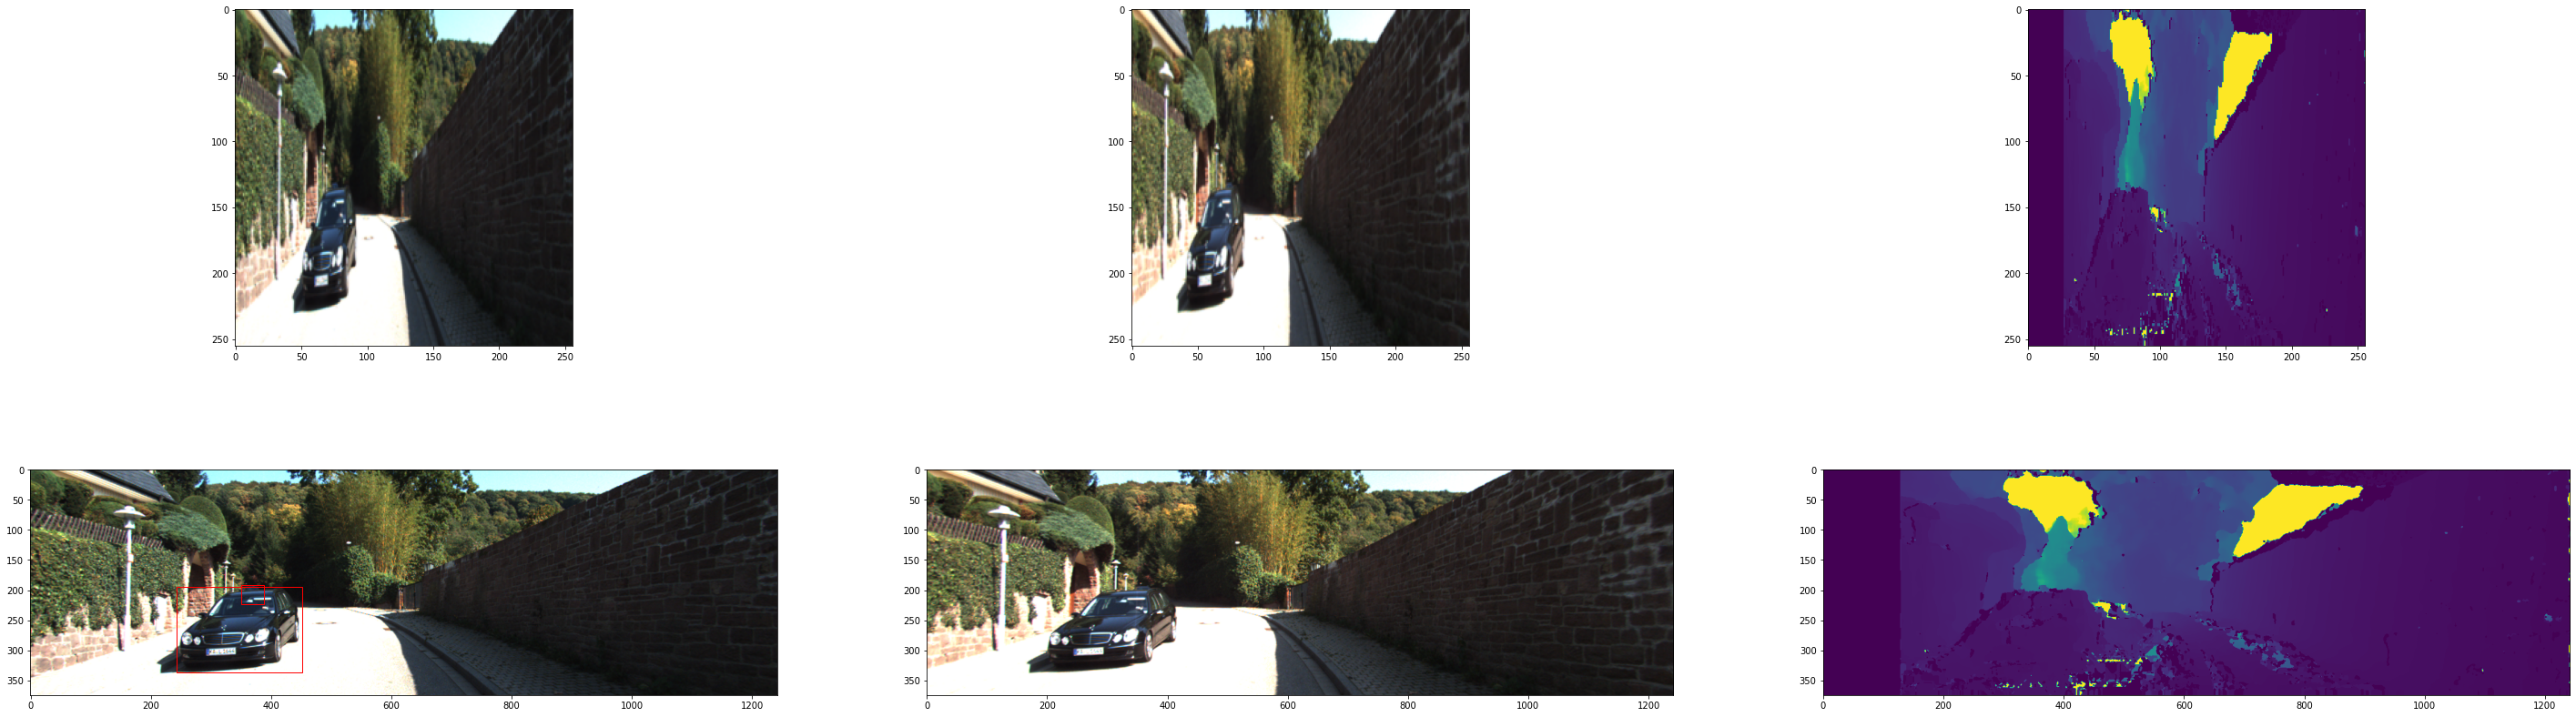

In [ ]:

idx = 5
inp_train, targ_train = train_ds[idx]
inp_high = display_ds[idx]

fig, ax = plt.subplots(2, 3, figsize=(50,15) )
left = inp_train[:3].cpu()
right = inp_train[3:6].cpu()
depth = inp_train[6:].cpu()
ax[0,0].imshow(left.permute(1,2,0))
ax[0,1].imshow(right.permute(1,2,0))
ax[0,2].imshow(depth.squeeze(0))

left_high = inp_high[0:3]
right_high = inp_high[3:6]   
depth_high = inp_high[6:]   
ax[1,0].imshow(left_high.permute(1,2,0))
ax[1,1].imshow(right_high.permute(1,2,0))
ax[1,2].imshow(depth_high.squeeze(0))

## check target
for i in range(targ_train.shape[1]):
    for j in range(targ_train.shape[2]):
        if torch.sum(targ_train[:9,i,j])!=0:
            print(targ_train[:,i,j])
            x_targ = targ_train[9,i,j] 
            y_targ = targ_train[10,i,j] 
            w_targ = targ_train[11,i,j] - targ_train[9,i,j]
            h_targ = targ_train[12,i,j] - targ_train[10,i,j]
            
            # print(targ[i,j,12], targ[i,j,10], targ[i,j,12] - targ[i,j,10])
            rect_targ = patches.Rectangle((x_targ,y_targ), w_targ, h_targ, linewidth=1, edgecolor='r', facecolor='none')
            # targ_boxes.append(rect)
            # ax[0,0].add_patch(rect_targ)
            ax[1,0].add_patch(rect_targ)
           

In [ ]:

inp_train, targ_train = train_ds[3]
inp_test, targ_test = test_ds[3]

left = inp_test[:3].cpu()
right = inp_test[3:].cpu()

with torch.no_grad():
    pred = net(inp_train.unsqueeze(0)).squeeze().cpu()

NameError: ignored

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,10) )
ax[0].imshow(left.permute(1,2,0))
ax[1].imshow(right.permute(1,2,0))


boxes3D_all = []
for i in range(pred.shape[1]):
    for j in range(pred.shape[2]):
        b = torch.cat((pred[:9,i,j], pred[-4:-1,i,j], pred[-7:-4,i,j], pred[9:13,i,j]))
        boxes3D_all.append(b.tolist())

# segregate with class
boxes3D_seg_class = [[] for c in range(0,9)]
thresh = 1e-2
for i in range(0,9):
    for b in boxes3D_all:
        if (b[i] >= thresh):
            boxes3D_seg_class[i].append([b[i]] + b[9:])

# remove empty lists
boxes3D_seg_class = [b for b in boxes3D_seg_class if len(b) > 0]
# print(boxes3D_seg_class)
# NMS
boxes3D_nms = [nms(np.array(b[:7]))[0] + b[-4:] for b in boxes3D_seg_class]

print(boxes3D_nms)
## Display
for b_list in boxes3D_nms:
    for b in b_list:
        # PREDICTIONS
        # print(pred[:9,i,j])
        x_pred = b[-4]
        y_pred = b[-3]
        w_pred = b[-2] - b[-4]
        h_pred = b[-1] - b[-3]

        rect_pred = patches.Rectangle((x_pred,y_pred), w_pred, h_pred, linewidth=1, edgecolor='r', facecolor='none')

        ax[0].add_patch(rect_pred)


## 3D bounding box coordinates from target tensor

In [ ]:
P2 = np.array([
        [7.070493000000e+02, 0.000000000000e+00, 6.040814000000e+02, 04.575831000000e+01],
        [0.000000000000e+00, 7.070493000000e+02, 1.805066000000e+02, -3.454157000000e-01],
        [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00, 04.981016000000e-03],
])
R0_rect = np.array([
        [ 9.999128000000e-01, 1.009263000000e-02, -8.511932000000e-03, 0.000000000000e+00],
        [-1.012729000000e-02, 9.999406000000e-01, -4.037671000000e-03, 0.000000000000e+00],
        [ 8.470675000000e-03, 4.123522000000e-03,  9.999556000000e-01, 0.000000000000e+00],
        [ 0.000000000000e+00, 0.000000000000e+00,  0.000000000000e+00, 1.000000000000e+00],
])

def get3DBox(target_vector):
    # center = (centerx, centery, centerz)
    center = target_vector[-4:-1]
    centerx, centery, centerz = center
    rot_rad = target_vector[-1]
    dims = target_vector[-7:-4]
    height, width, depth = dims

    coords = np.array([
                        [centerx - width/2, centery + height/2, centerz - depth/2],
                        [centerx + width/2, centery + height/2, centerz - depth/2],
                        [centerx + width/2, centery - height/2, centerz - depth/2],
                        [centerx - width/2, centery - height/2, centerz - depth/2],
                        [centerx - width/2, centery + height/2, centerz + depth/2],
                        [centerx + width/2, centery + height/2, centerz + depth/2],
                        [centerx + width/2, centery - height/2, centerz + depth/2],
                        [centerx - width/2, centery - height/2, centerz + depth/2],
                    ])

    # sanity check: WORKS
    # print(coords) 
    # rotate all points about center
    # sanity check
    # print(rot_rad*180/np.pi)
    rot_coords = np.array([rotate_point(coord.copy(), center, -rot_rad) for coord in coords])
    
    # perspective transform         
    # print(rot_coords[0].reshape(1,3).T)   
    x_vecs = [np.vstack((rot_coord.reshape(1,3).T, [1])) for rot_coord in coords]
    # print(x_vecs)
    coord_projn = [np.dot(P2, np.dot(R0_rect, x_vec)) for x_vec in x_vecs]
    coord_projn = [(p/p[2,0])[:2].T.reshape(2) for p in coord_projn]
    return coords, rot_coords, coord_projn

def rotate_point(point1, point2, rot_rad):

    rot_mat = np.array([[np.cos(rot_rad), -np.sin(rot_rad)],
                        [np.sin(rot_rad), np.cos(rot_rad)]])
    p1 = np.array([point1[0], point1[2]])
    p2 = np.array([point2[0], point2[2]])
    p1 = p2 + np.dot(p1-p2, rot_mat)
    point1[0] = p1[0]
    point1[2] = p1[1]
    return point1

In [ ]:
dummy_target_vector = np.array([  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
                                0.0000,   1.0000,   0.0000, 148.7900,  85.4500, 256.9900,   1.4800,
                                1.5500,   3.2900,  -9.7500,   1.0600,  10.1400,   2.9300])
bbox3D, bbox3D_rot, bbox3D_projn = get3DBox(dummy_target_vector)

In [ ]:
print(bbox3D)
print(bbox3D_rot)
for p in bbox3D_projn:
    print(p)

[[-10.525   1.8     8.495]
 [ -8.975   1.8     8.495]
 [ -8.975   0.32    8.495]
 [-10.525   0.32    8.495]
 [-10.525   1.8    11.785]
 [ -8.975   1.8    11.785]
 [ -8.975   0.32   11.785]
 [-10.525   0.32   11.785]]
[[ -8.646806   1.8       11.585549]
 [-10.162237   1.8       11.911076]
 [-10.162237   0.32      11.911076]
 [ -8.646806   0.32      11.585549]
 [ -9.337763   1.8        8.368924]
 [-10.853194   1.8        8.694451]
 [-10.853194   0.32       8.694451]
 [ -9.337763   0.32       8.368924]]
[-279.345726  337.610552]
[-147.99362   336.049472]
[-149.791984  211.962341]
[-281.242193  213.330871]
[-32.795222 292.662332]
[ 61.412298 291.589773]
[ 60.228059 202.326867]
[-34.029922 203.299831]


In [ ]:
import matplotlib.lines as lines

def get3DBoxEdges(coord_projn):

    edges = [
                  lineBwPoints(coord_projn[0], coord_projn[1]),
                  lineBwPoints(coord_projn[1], coord_projn[2]),
                  lineBwPoints(coord_projn[2], coord_projn[3]),
                  lineBwPoints(coord_projn[3], coord_projn[0]),
                  
                  lineBwPoints(coord_projn[4], coord_projn[5]),
                  lineBwPoints(coord_projn[5], coord_projn[6]),
                  lineBwPoints(coord_projn[6], coord_projn[7]),
                  lineBwPoints(coord_projn[7], coord_projn[4]),
                  
                  lineBwPoints(coord_projn[0], coord_projn[4]),
                  lineBwPoints(coord_projn[1], coord_projn[5]),
                  lineBwPoints(coord_projn[2], coord_projn[6]),
                  lineBwPoints(coord_projn[3], coord_projn[7])
    ]
    return edges

def lineBwPoints(p1, p2):
    return lines.Line2D([p1[0], p2[0]], [p1[1], p2[1]], linewidth=1, linestyle='-', color = "blue")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  6.8850e+02,
         1.7145e+02,  8.4408e+02,  2.4082e+02,  1.6200e+00,  1.4700e+00,
         3.6600e+00,  3.9400e+00,  1.6000e+00,  1.8380e+01, -3.8000e-01,
        -5.9000e-01])
tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  5.1687e+02,
         1.6854e+02,  5.8198e+02,  2.6766e+02,  1.7900e+00,  4.7000e-01,
         1.7500e+00, -1.2400e+00,  1.7300e+00,  1.3920e+01,  1.0000e+00,
         1.0900e+00])
tensor([  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   1.0000, 386.5000, 195.3400, 547.0300, 325.1300,   1.3800,
          1.4300,   3.6400,  -1.8300,   1.7400,  10.0000,   1.5900,   1.7700])
tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  9.4

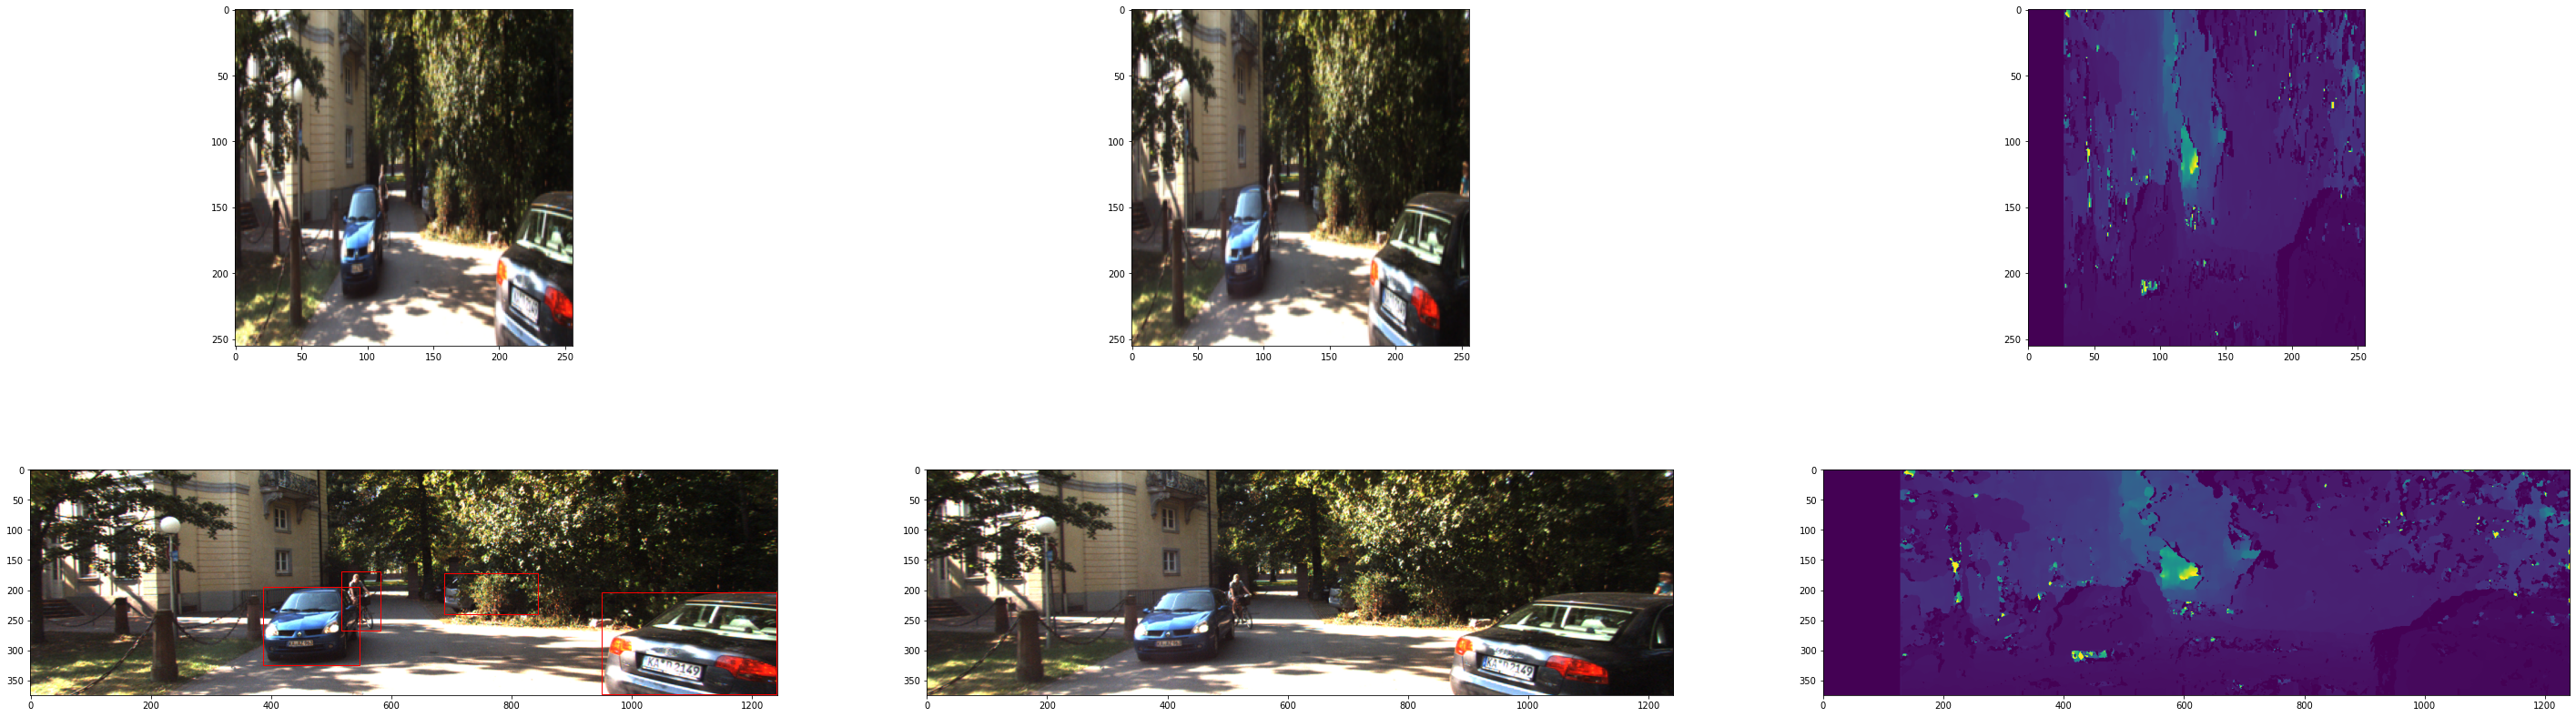

In [ ]:

idx = 6
inp_train, targ_train = train_ds[idx]
inp_high = display_ds[idx]

fig, ax = plt.subplots(2, 3, figsize=(50,15) )
left = inp_train[:3].cpu()
right = inp_train[3:6].cpu()
depth = inp_train[6:].cpu()
ax[0,0].imshow(left.permute(1,2,0))
ax[0,1].imshow(right.permute(1,2,0))
ax[0,2].imshow(depth.squeeze(0))

left_high = inp_high[0:3]
right_high = inp_high[3:6]   
depth_high = inp_high[6:]   
ax[1,0].imshow(left_high.permute(1,2,0))
ax[1,1].imshow(right_high.permute(1,2,0))
ax[1,2].imshow(depth_high.squeeze(0))

## check target
for i in range(targ_train.shape[1]):
    for j in range(targ_train.shape[2]):
        if torch.sum(targ_train[:9,i,j])!=0:
            print(targ_train[:,i,j])
            # _, _, bbox3D_projn = get3DBox(targ_train[:,i,j])
            
            # print(bbox3D_projn)
            
            # for v in bbox3D_projn:
                # ax[1,0].scatter(v[0], v[1])
            
            # edges = get3DBoxEdges(bbox3D_projn)
            # for e in edges:   
                # ax[1,0].add_artist(e)

            x_targ = targ_train[9,i,j]
            y_targ = targ_train[10,i,j]
            w_targ = targ_train[11,i,j] - targ_train[9,i,j]
            h_targ = targ_train[12,i,j] - targ_train[10,i,j]
            # print(targ[i,j,12], targ[i,j,10], targ[i,j,12] - targ[i,j,10])
            rect_targ = patches.Rectangle((x_targ,y_targ), w_targ, h_targ, linewidth=1, edgecolor='r', facecolor='none')
            ax[1,0].add_patch(rect_targ)

            

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


tensor([ 0.0000e+00,  1.9813e-29,  0.0000e+00,  0.0000e+00,  1.2575e-17,
         1.2254e-32,  7.6417e-30,  0.0000e+00,  0.0000e+00,  2.0453e+02,
         1.7447e+02,  2.7956e+02,  2.3253e+02,  1.2855e+00,  7.8628e-01,
         2.9144e+00, -1.6547e+02, -1.5334e+02, -1.2275e+02, -7.1295e-01,
         4.2196e-01])
tensor([ 0.0000e+00,  2.0597e-22,  0.0000e+00,  0.0000e+00,  2.4556e-18,
         2.6662e-31,  7.5894e-27,  0.0000e+00,  0.0000e+00,  2.2987e+02,
         1.7719e+02,  3.2165e+02,  2.3564e+02,  1.6058e+00,  1.3683e+00,
         3.5580e+00, -8.1057e+01, -6.8341e+01, -3.8619e+01,  3.8725e-01,
         9.5461e-01])
tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.2718e-18,
         6.8256e-39,  0.0000e+00,  0.0000e+00,  0.0000e+00,  2.9054e+01,
         1.8495e+02,  1.1275e+02,  2.7432e+02,  7.0000e-01,  1.4534e-01,
         2.5094e+00, -3.0859e+02, -2.9664e+02, -2.7717e+02, -3.0862e+00,
        -1.3711e+00])
tensor([ 0.0000e+00,  1.2202e-25,  4.8229e-38,  0.0000e+00

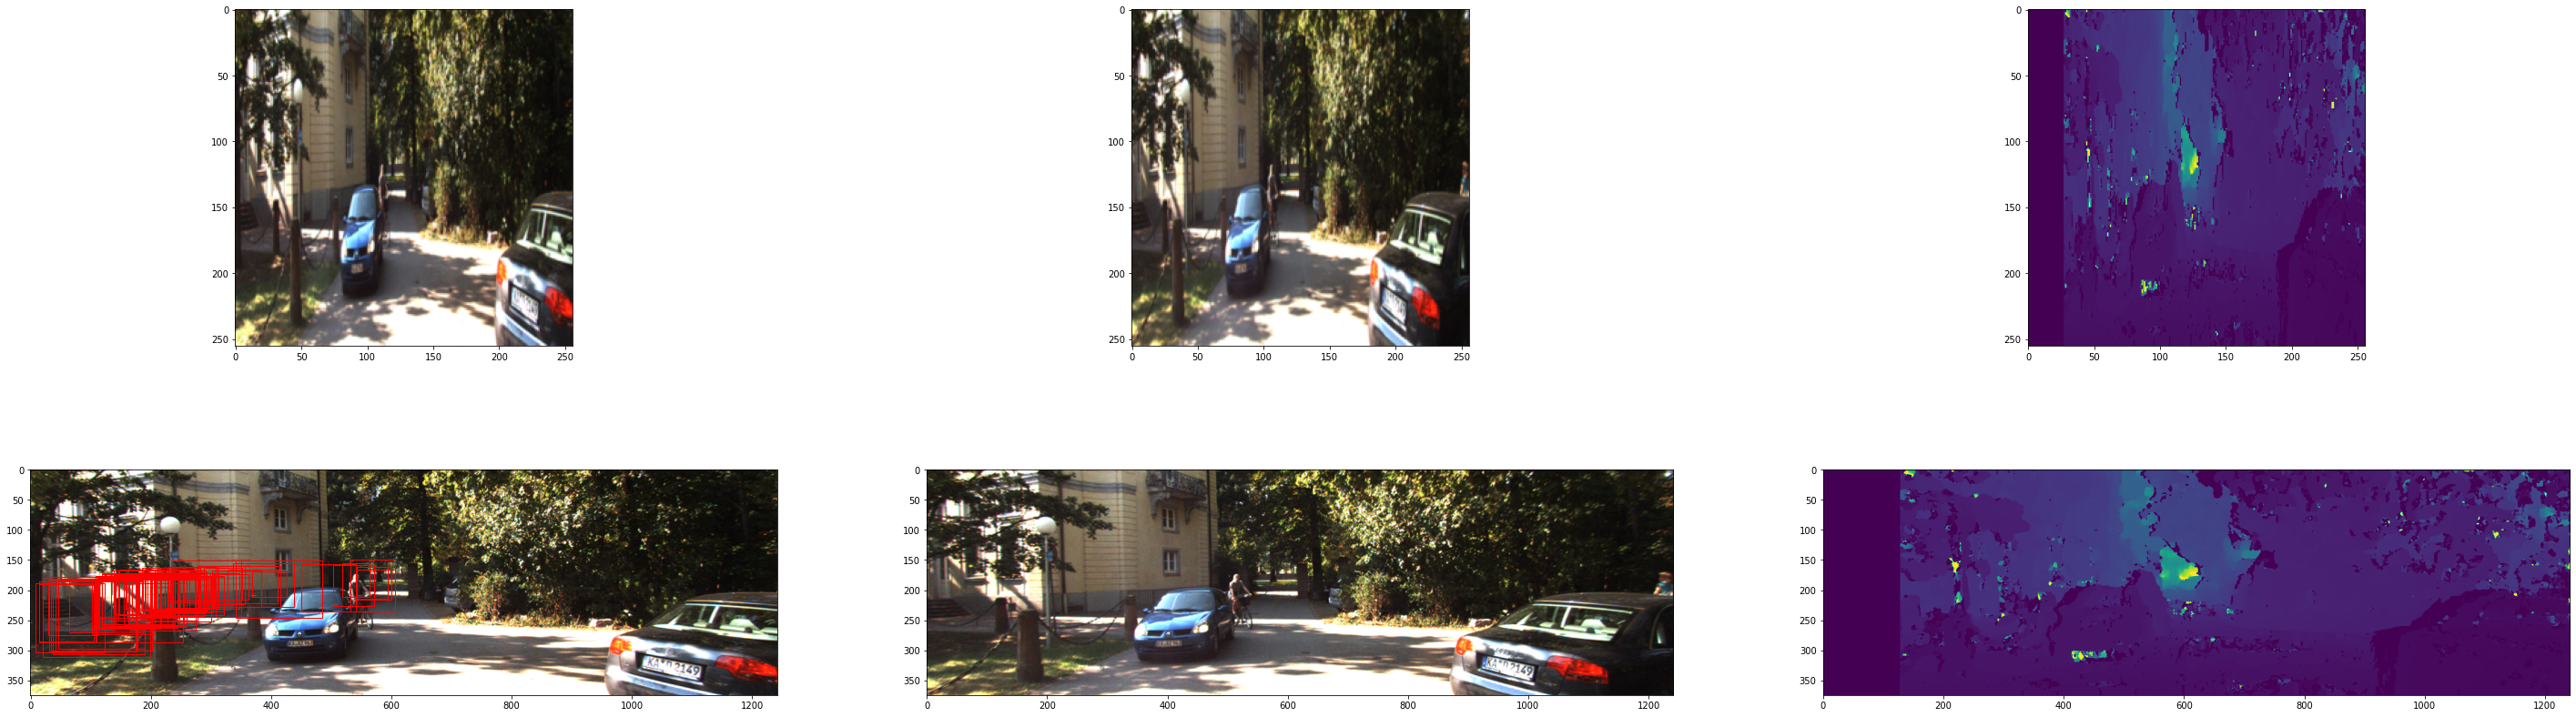

In [ ]:
idx = 6
inp_train, targ_train = train_ds[idx]
inp_high = display_ds[idx]

fig, ax = plt.subplots(2, 3, figsize=(50,15) )
left = inp_train[:3].cpu()
right = inp_train[3:6].cpu()
depth = inp_train[6:].cpu()
ax[0,0].imshow(left.permute(1,2,0))
ax[0,1].imshow(right.permute(1,2,0))
ax[0,2].imshow(depth.squeeze(0))

left_high = inp_high[0:3]
right_high = inp_high[3:6]   
depth_high = inp_high[6:]   
ax[1,0].imshow(left_high.permute(1,2,0))
ax[1,1].imshow(right_high.permute(1,2,0))
ax[1,2].imshow(depth_high.squeeze(0))


with torch.no_grad():
    pred = net(inp_train.unsqueeze(0)).squeeze().cpu()

## check target
for i in range(pred.shape[1]):
    for j in range(pred.shape[2]):
        p = [p>1e-18 for p in pred[:9,i,j]]

        if sum(p) > 0:
            print(pred[:,i,j])
            _, _, bbox3D_projn = get3DBox(pred[:,i,j])
            
            # for b in bbox3D_projn:    
                # ax.scatter(b[0], b[1])

            # edges = get3DBoxEdges(bbox3D_projn)
            # for e in edges:   
                # ax.add_artist(e)

            # PREDICTIONS
            # print(pred[:9,i,j])
            x_pred = pred[9,i,j]
            y_pred = pred[10,i,j]
            w_pred = pred[11,i,j] - pred[9,i,j]
            h_pred = pred[12,i,j] - pred[10,i,j]

            # print(targ[i,j,12], targ[i,j,10], targ[i,j,12] - targ[i,j,10])
            rect_pred = patches.Rectangle((x_pred,y_pred), w_pred, h_pred, linewidth=1, edgecolor='r', facecolor='none')
            # targ_boxes.append(rect)
            ax[1,0].add_patch(rect_pred)

## NMS

In [ ]:

import numpy as np
import time

# This approach assumes there are prediction scores (one class only) in the incoming bounding boxes as well.
# Selects best score and then suppresses.
# class score + bounding box = (p, x, y, z, w, h, l)
# p: classification score / probability
# x,y,z: location
# w,h,l: dimensions

iou_threshold = 0


def iou(box_a, box_b):

    box_a_top_right_corner = [box_a[1]+box_a[3], box_a[2]+box_a[4]]
    box_b_top_right_corner = [box_b[1]+box_b[3], box_b[2]+box_b[4]]

    box_a_area = (box_a[3]) * (box_a[4])
    box_b_area = (box_b[3]) * (box_b[4])

    xi = max(box_a[1], box_b[1])
    yi = max(box_a[2], box_b[2])

    corner_x_i = min(box_a_top_right_corner[0], box_b_top_right_corner[0])
    corner_y_i = min(box_a_top_right_corner[1], box_b_top_right_corner[1])

    intersection_area = max(0, corner_x_i - xi) * max(0, corner_y_i - yi)

    intersection_l_min = max(box_a[3], box_b[3])
    intersection_l_max = min(box_a[3]+box_a[6], box_b[3]+box_b[6])
    intersection_length = intersection_l_max - intersection_l_min

    iou = (intersection_area * intersection_length) / float(box_a_area * box_a[6] + box_b_area * box_b[6]
                                                            - intersection_area * intersection_length + 1e-5)

    return iou


def nms(original_boxes):

    boxes_probability_sorted = original_boxes[np.flip(np.argsort(original_boxes[:, 0]))]
    box_indices = np.arange(0, len(boxes_probability_sorted))
    suppressed_box_indices = []
    tmp_suppress = []

    while len(box_indices) > 0:

        if box_indices[0] not in suppressed_box_indices:
            selected_box = box_indices[0]
            tmp_suppress = []

            for i in range(len(box_indices)):
                if box_indices[i] != selected_box:
                    selected_iou = iou(boxes_probability_sorted[selected_box], boxes_probability_sorted[box_indices[i]])
                    if selected_iou > iou_threshold:
                        suppressed_box_indices.append(box_indices[i])
                        tmp_suppress.append(i)

        box_indices = np.delete(box_indices, tmp_suppress, axis=0)
        box_indices = box_indices[1:]

    preserved_boxes = np.delete(boxes_probability_sorted, suppressed_box_indices, axis=0)
    return preserved_boxes, suppressed_box_indices


if __name__ == "__main__":

    # some random test bounding box data, feel free to try out your own.
    box_0 = np.array([0.96, 10, 10, 10, 10, 10, 10])  # should make it
    box_1 = np.array([0.90, 10, 10, 10, 11, 11, 12])

    box_2 = np.array([0.76, 21, 10, 13, 10, 9.5, 7])
    box_3 = np.array([0.80, 20.5, 12, 10, 11, 11, 12])
    box_4 = np.array([0.92, 21.5, 11, 10, 10, 10.3, 10])  # should make it

    box_5 = np.array([0.77, 3.9, 2, 2.5, 4, 6.5, 12])
    box_6 = np.array([0.84, 4, 2, 2.5, 4, 6.6, 10])  # should make it
    box_7 = np.array([0.95, 2.99, 2.65, 4.5, 4, 6.35, 12])  # should make it

    box_8 = np.array([0.84, 32, 33, 69, 33.2, 10.2, 6.5])  # should make it

    box_9 = np.array([0.89, 43, 44, 55.5, 11, 11, 12])
    box_10 = np.array([0.93, 41.4, 46, 56.6, 12, 10, 10])  # should make it

    boxes = np.array([box_0, box_1, box_2, box_3,
                      box_4, box_5, box_6,
                      box_7, box_8, box_9, box_10])

    print("{} Input Bounding Boxes (p,x,y,z,w,h,l):".format(len(boxes)))
    print(boxes)
    print()

    start = time.time()
    p, s = nms(boxes)
    end = time.time()

    print("{} seconds".format(end-start))
    print("{} Post-NMS Bounding Boxes (p,x,y,z,w,h,l):".format(len(p)))
    print(p)
    print()

11 Input Bounding Boxes (p,x,y,z,w,h,l):
[[ 0.96 10.   10.   10.   10.   10.   10.  ]
 [ 0.9  10.   10.   10.   11.   11.   12.  ]
 [ 0.76 21.   10.   13.   10.    9.5   7.  ]
 [ 0.8  20.5  12.   10.   11.   11.   12.  ]
 ...
 [ 0.95  2.99  2.65  4.5   4.    6.35 12.  ]
 [ 0.84 32.   33.   69.   33.2  10.2   6.5 ]
 [ 0.89 43.   44.   55.5  11.   11.   12.  ]
 [ 0.93 41.4  46.   56.6  12.   10.   10.  ]]

0.0005049705505371094 seconds
5 Post-NMS Bounding Boxes (p,x,y,z,w,h,l):
[[ 0.96 10.   10.   10.   10.   10.   10.  ]
 [ 0.95  2.99  2.65  4.5   4.    6.35 12.  ]
 [ 0.93 41.4  46.   56.6  12.   10.   10.  ]
 [ 0.92 21.5  11.   10.   10.   10.3  10.  ]
 [ 0.84 32.   33.   69.   33.2  10.2   6.5 ]]




## Disparity calculation from stereo iamges

In [ ]:

print(PATH)

drive/MyDrive/playground/training/


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide


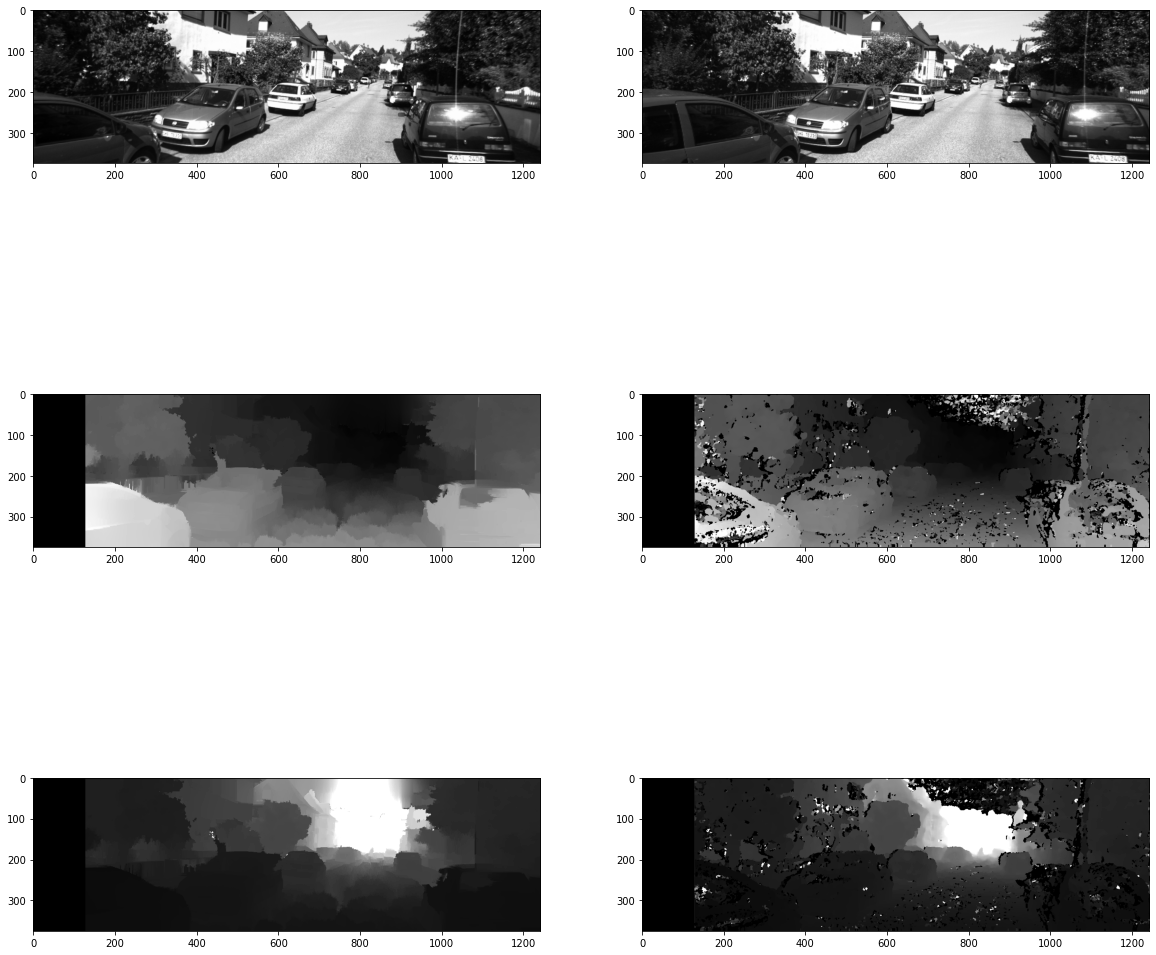

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt 

wsize=31
max_disp = 128
sigma = 1.5
lmbda = 8000.0
idx = 8
imgL = cv2.imread(f"{PATH}image_2/00000{idx}.png", 0)
imgR = cv2.imread(f"{PATH}image_3/00000{idx}.png", 0)

meanL, stdL = cv2.meanStdDev(imgL)
meanR, stdR = cv2.meanStdDev(imgR)
normR = np.clip(((((imgR-meanR)/stdR) *stdL)+meanL), 0, 255).astype(np.uint8)
# normL = cv2.normalize(imgL, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
# normR = cv2.normalize(imgR, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

left_matcher = cv2.StereoSGBM_create(
    minDisparity = 0,
    numDisparities= 128, 
    blockSize=11,
    speckleRange=5)
right_matcher = cv2.ximgproc.createRightMatcher(left_matcher);
left_disp = left_matcher.compute(imgL, normR)
# left_disp = cv2.normalize(left_disp, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
right_disp = right_matcher.compute(normR, imgL)
                                 
# # Now create DisparityWLSFilter
wls_filter = cv2.ximgproc.createDisparityWLSFilter(left_matcher);
wls_filter.setLambda(lmbda);
wls_filter.setSigmaColor(sigma);
filtered_disp = wls_filter.filter(left_disp, imgL, disparity_map_right=right_disp);

# Disparity to depth
baseline = 0.54
focal_length = 721.5377
depth = (baseline * focal_length) / (left_disp)
depth = np.clip(depth, 0, 5)
depth_filtered = baseline * focal_length / (filtered_disp)
depth_filtered = np.clip(depth_filtered, 0, 5)
# ## normalize depth to be able to plot
depth_norm = cv2.normalize(depth, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
depth_filtered = cv2.normalize(depth_filtered, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

fig, ax = plt.subplots(3,2, figsize=(20,20))
ax[0][0].imshow(cv2.cvtColor(normR, cv2.COLOR_BGR2RGB))
ax[0][1].imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
ax[1][0].imshow(filtered_disp,'gray');
ax[1][1].imshow(left_disp,'gray');
# ax[2][0].imshow(depth_norm, 'gray');
ax[2][0].imshow(depth_filtered, 'gray');
ax[2][1].imshow(depth_norm, 'gray');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


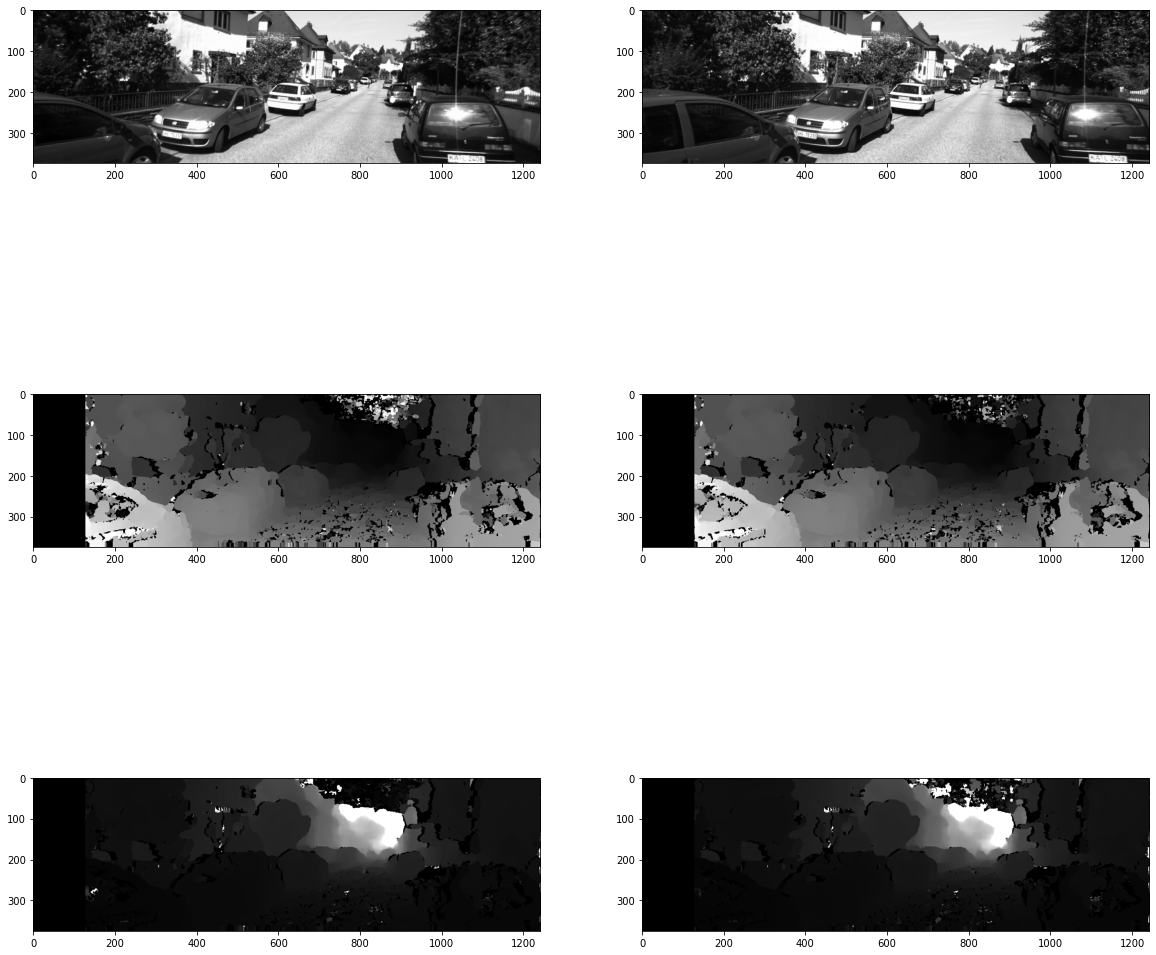

In [ ]:
## Norm vs no Norm: no norm is SLIGHTLY better
import numpy as np
import cv2
from matplotlib import pyplot as plt 

wsize=31
max_disp = 128
sigma = 1.5
lmbda = 8000.0
idx = 8
imgL = cv2.imread(f"{PATH}image_2/00000{idx}.png", 0)
imgR = cv2.imread(f"{PATH}image_3/00000{idx}.png", 0)

meanL, stdL = cv2.meanStdDev(imgL)
meanR, stdR = cv2.meanStdDev(imgR)
normR = np.clip(((((imgR-meanR)/stdR) * stdL)+meanL), 0, 255).astype(np.uint8)

left_matcher = cv2.StereoSGBM_create(
    minDisparity = 0,
    numDisparities= 128, 
    blockSize=21,
    speckleRange=2,
)
left_disp = left_matcher.compute(imgL, imgR)
left_disp_norm = left_matcher.compute(imgL, normR)

# Disparity to depth
baseline = 0.54
focal_length = 721.5377
depth = (baseline * focal_length) / (left_disp)
depth = np.clip(depth, 0, 10)
# ## normalize depth to be able to plot
depth_norm = (baseline * focal_length) / (left_disp_norm)
depth_norm = np.clip(depth_norm, 0, 10)
depth_norm = cv2.normalize(depth_norm, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
fig, ax = plt.subplots(3,2, figsize=(20,20))
ax[0][0].imshow(cv2.cvtColor(normR, cv2.COLOR_BGR2RGB))
ax[0][1].imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
ax[1][0].imshow(left_disp_norm,'gray');
ax[1][1].imshow(left_disp,'gray');
# ax[2][0].imshow(depth_norm, 'gray');
ax[2][0].imshow(depth_norm, 'gray');
ax[2][1].imshow(depth, 'gray');

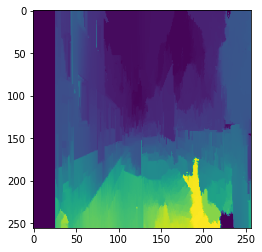

In [ ]:
temp = tfms_disparity_train(filtered_disp)
plt.imshow(temp.squeeze(0))

In [ ]:
BCE_loss = nn.BCELoss(reduction="mean")

inp = torch.zeros(1)
targ = torch.ones(1)
print(BCE_loss(inp, targ) * 1e4)

tensor(1000000.)
